### Notebook Imports

In [228]:
import os
import sys
import math
import time

from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image

import nltk
nltk.download('punkt')
from torchvision import transforms
from vocabulary import Vocabulary
from tqdm import tqdm

import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torchvision.models as models
from model import EncoderCNN, DecoderRNN

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


### Initalizing COCO API

In [2]:
sys.path.append('/opt/cocoapi/PythonAPI')

dataType = 'val2017'
instances_annFile = './cocoapi/images/coco2017/annotations/instances_' + dataType + '.json'
coco = COCO(instances_annFile)

captions_annFile = './cocoapi/images/coco2017/annotations/captions_' + dataType + '.json'
coco_caps = COCO(captions_annFile)

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=1.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


### Exploring dataset

In [176]:
coco.loadImgs(170893)[0]

{'license': 1,
 'file_name': '000000170893.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000170893.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-15 01:18:27',
 'flickr_url': 'http://farm1.staticflickr.com/8/12252881_fda2f8c3e8_z.jpg',
 'id': 170893}

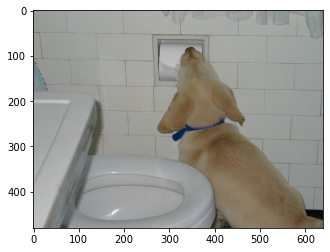

In [191]:
coco_caps.loadImgs(170893)[0]
I = io.imread('./cocoapi/images/coco2017/' + dataType + '/000000170893.jpg')
plt.imshow(I)
plt.show()

In [185]:
coco_caps.getAnnIds(imgIds=170893)

[146852, 155228, 158549, 158714, 159191]

In [187]:
coco_caps.loadAnns([146852, 155228, 158549, 158714, 159191])

[{'image_id': 170893,
  'id': 146852,
  'caption': 'A dog is standing next to a toilet playing with tissue'},
 {'image_id': 170893,
  'id': 155228,
  'caption': 'A dog in the bathroom reaching for the toilet paper.'},
 {'image_id': 170893,
  'id': 158549,
  'caption': 'A yellow dog smelling the toilet paper in a bathroom.'},
 {'image_id': 170893,
  'id': 158714,
  'caption': 'A dog uses its mouth to grab toilet paper off of the roll.'},
 {'image_id': 170893,
  'id': 159191,
  'caption': 'a dog eating toilet paper from the toilet paper holder'}]

In [192]:
coco_caps.showAnns(coco_caps.loadAnns([146852, 155228, 158549, 158714, 159191]))

A dog is standing next to a toilet playing with tissue
A dog in the bathroom reaching for the toilet paper.
A yellow dog smelling the toilet paper in a bathroom.
A dog uses its mouth to grab toilet paper off of the roll.
a dog eating toilet paper from the toilet paper holder


#### Sample Image

http://images.cocodataset.org/val2017/000000007795.jpg


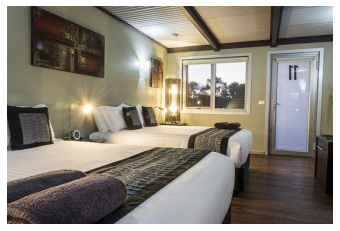

A narrow hotel room with two made up beds.
a large modern hotel room with double beds
A couple of large beds in a small room.
A hotel room with two beds side by side  .
Two beds are in a hotel room type setting.


In [3]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

### Pre-Processing

In [223]:
def get_loader(transform, batch_size=1, vocab_threshold=None, vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True):

    img_folder = './cocoapi/images/coco2017/train2017/'
    annotations_file = './cocoapi/images/coco2017/annotations/captions_train2017.json'

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    # Randomly sample a caption length, and sample indices with that length.
    indices = dataset.get_train_indices()
    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
    # data loader for COCO dataset.
    data_loader = data.DataLoader(dataset=dataset, 
                                  batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                        batch_size=dataset.batch_size,
                                                                        drop_last=False))

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
    
        self.coco = COCO(annotations_file)
        self.ids = list(self.coco.anns.keys())
        print('Obtaining caption lengths')
        all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
        self.caption_lengths = [len(token) for token in all_tokens]
        
    def __getitem__(self, index):

        ann_id = self.ids[index]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        # Convert image to tensor and pre-process using transform
        image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        image = self.transform(image)

        # Convert caption to tensor of word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()

        # return pre-processed image and caption tensors
        return image, caption

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

In [222]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

vocab_threshold = 5 # minimum word count threshold for inclusion
batch_size = 10 # batch size

data_loader = get_loader(transform=transform_train,
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=4.76s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
Obtaining caption lengths


100%|██████████| 591753/591753 [00:42<00:00, 13852.74it/s]


In [6]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 10321


In [7]:
# Modify the minimum word count threshold.
vocab_threshold = 4

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:43<00:00, 13760.48it/s]


In [8]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 11543


In [227]:
data_loader.dataset.vocab.idx2word

{0: '<start>',
 1: '<end>',
 2: '<unk>',
 3: 'a',
 4: 'bicycle',
 5: 'replica',
 6: 'with',
 7: 'clock',
 8: 'as',
 9: 'the',
 10: 'front',
 11: 'wheel',
 12: '.',
 13: 'room',
 14: 'blue',
 15: 'walls',
 16: 'and',
 17: 'white',
 18: 'sink',
 19: 'door',
 20: 'car',
 21: 'that',
 22: 'seems',
 23: 'to',
 24: 'be',
 25: 'parked',
 26: 'illegally',
 27: 'behind',
 28: 'large',
 29: 'passenger',
 30: 'airplane',
 31: 'flying',
 32: 'through',
 33: 'air',
 34: 'there',
 35: 'is',
 36: 'plane',
 37: 'taking',
 38: 'off',
 39: 'in',
 40: 'partly',
 41: 'cloudy',
 42: 'sky',
 43: 'color',
 44: 'scheme',
 45: 'small',
 46: 'bathroom',
 47: 'this',
 48: 'wall',
 49: 'on',
 50: 'boat',
 51: 'themed',
 52: 'life',
 53: 'preserver',
 54: 'bike',
 55: 'has',
 56: 'tire',
 57: 'two',
 58: 'cars',
 59: 'sidewalk',
 60: 'street',
 61: 'an',
 62: ',',
 63: 'either',
 64: 'landing',
 65: 'or',
 66: 'just',
 67: 'are',
 68: 'painted',
 69: 'baby',
 70: 'toilet',
 71: 'shower',
 72: 'long',
 73: 'empty',

In [207]:
start_word = data_loader.dataset.vocab.start_word
print('All start words are mapped to this integer:', data_loader.dataset.vocab(start_word))

end_word = data_loader.dataset.vocab.end_word
print('All end words are mapped to this integer:', data_loader.dataset.vocab(end_word))

unk_word = data_loader.dataset.vocab.unk_word
print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

All start words are mapped to this integer: 0
All end words are mapped to this integer: 1
All unknown words are mapped to this integer: 2


In [224]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

sampled indices: [28973, 68836, 15701, 110953, 121079, 446753, 265408, 283318, 494739, 126492]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 13])


### Hyperparameters

In [13]:
batch_size = 128          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = False   # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained resnet model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:42<00:00, 13916.03it/s]


### Training

In [14]:
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), './models/' + 'decoder-%d.pkl' % epoch)
        torch.save(encoder.state_dict(), './models/' + 'encoder-%d.pkl' % epoch)

# Close the training log file.
f.close()

Epoch [1/3], Step [100/4624], Loss: 3.5963, Perplexity: 36.46279
Epoch [1/3], Step [200/4624], Loss: 3.5604, Perplexity: 35.1770
Epoch [1/3], Step [300/4624], Loss: 3.2035, Perplexity: 24.6183
Epoch [1/3], Step [400/4624], Loss: 3.0793, Perplexity: 21.7441
Epoch [1/3], Step [500/4624], Loss: 2.9344, Perplexity: 18.8097
Epoch [1/3], Step [600/4624], Loss: 2.9602, Perplexity: 19.3009
Epoch [1/3], Step [700/4624], Loss: 2.8415, Perplexity: 17.1419
Epoch [1/3], Step [800/4624], Loss: 2.8241, Perplexity: 16.8451
Epoch [1/3], Step [900/4624], Loss: 2.5827, Perplexity: 13.2332
Epoch [1/3], Step [1000/4624], Loss: 2.5638, Perplexity: 12.9850
Epoch [1/3], Step [1100/4624], Loss: 2.5364, Perplexity: 12.63469
Epoch [1/3], Step [1200/4624], Loss: 2.5757, Perplexity: 13.1410
Epoch [1/3], Step [1300/4624], Loss: 2.5221, Perplexity: 12.4553
Epoch [1/3], Step [1400/4624], Loss: 2.3476, Perplexity: 10.4601
Epoch [1/3], Step [1500/4624], Loss: 2.5682, Perplexity: 13.0421
Epoch [1/3], Step [1600/4624], L